# 모델링 실험 계획

## 1) 피처 엔지니어링/선택
- 상관 분석을 바탕으로 중복·강 상관 피처 정리
- 예시: 편의 시설 점수 = 장애인 시설 점수 + 편의 시설 점수, 성별 비율은 한 축만 사용(예: 여성 비율만 유지)
- 검증: 피처 선택 전/후 성능 비교

## 2) 인코딩 전략 비교
1. CatBoost 원본 사용: 범주형 인코딩 없이 사용
2. 일부 원-핫: 범주 수 적은 컬럼만 원-핫 + CatBoost
3. 혼합 인코딩: (2) + 나머지 범주형은 평균 인코딩
4. 전체 원-핫: 모든 범주형 원-핫 인코딩 후 트리/선형계열 모델
- 비교: (2)~(3) 중 우세 전략 vs 전체 원-핫 전략

## 3) 방법론(모델) 검증
- 후보: CatBoost, RandomForest, GradientBoosting 등
- 인코딩 전략에서의 우세 방식과 결합하여 5가지 내외 조합 비교

## 4) 검증 절차/지표
- 데이터 분할: 고정 시드 train/test split, 필요 시 K-fold 교차검증
- 평가지표: RMSE(주), 보조로 R² 등
- 일관된 전처리/스케일링 규칙 유지

## 5) 최종 선택 기준
- 평균 성능(낮은 RMSE), 분산(안정성), 해석 가능성, 구현·운영 복잡도
- 위 기준으로 최종 모델·인코딩·피처 세트 확정

In [ ]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import AdaBoostRegressor


try:
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None 

warnings.filterwarnings('ignore')

In [ ]:
# 데이터 경로 설정 및 로딩 함수
DATA_DIR = '../data/02_Data_Preprocessing/df_3차_전처리_후'
ML_FINAL_PATH = os.path.join(DATA_DIR, 'machine_learning_final.xlsx')


def load_ml_data(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        print(f"경고: '{path}' 파일이 없습니다. 데이터 로드를 건너뜁니다.")
        return pd.DataFrame()
    return pd.read_excel(path, index_col=0)

Saving machine_learning.xlsx to machine_learning.xlsx


In [ ]:
ml_df = load_ml_data(ML_FINAL_PATH)
ml_df = ml_df.drop(['회차당 평균 관객 수', '공연시설코드', '시설특성'], axis = 1).copy()

# 변수간 상관관계 히트맵

In [ ]:
# 지정된 수치 컬럼만 존재 여부 확인 후 사용
numerical_columns = ['좌석수', '공연회차', '장애인 시설 점수', '편의 시설 점수', '남성 관람객 비율(%)', '여성 관람객 비율(%)', '좌석 수 대비 관객 수']
num_cols = [c for c in numerical_columns if c in ml_df.columns]

df_numerical = ml_df[num_cols].copy()
df_categorical = ml_df.drop(columns=num_cols, errors='ignore').copy()

##### 수치형 변수

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


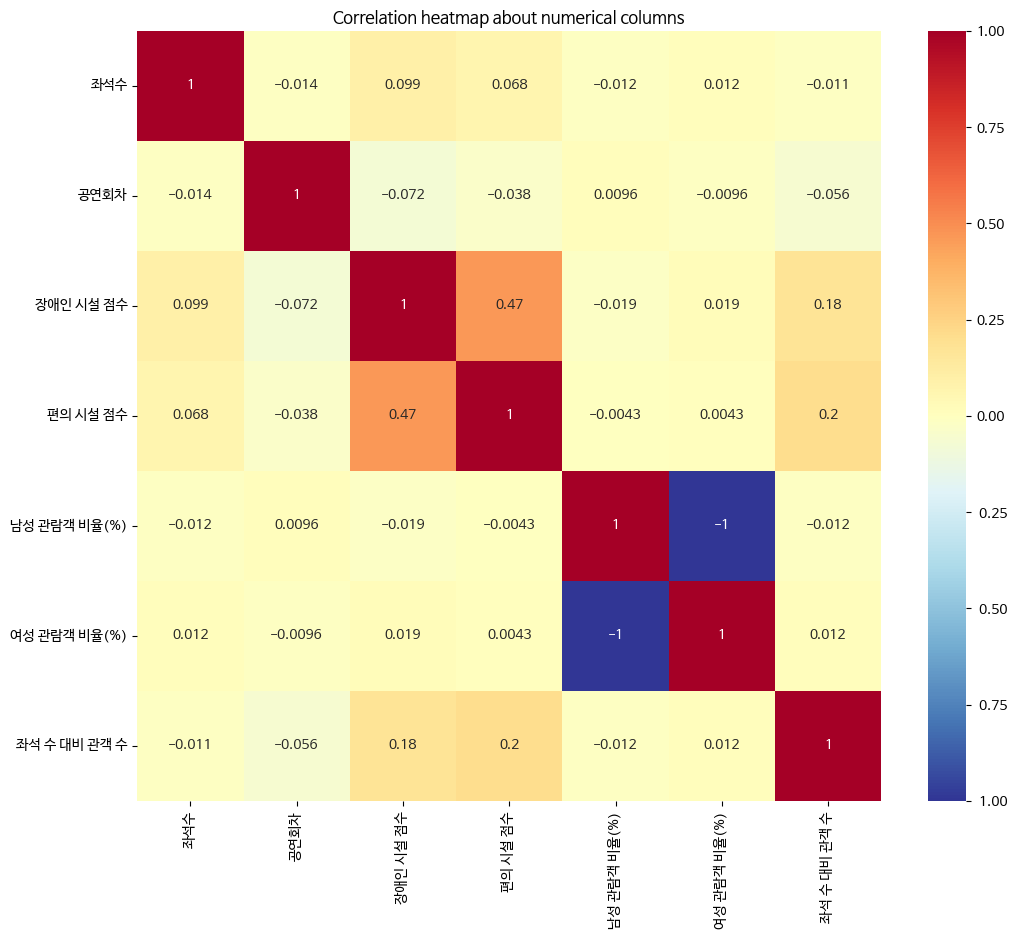

In [12]:
#한글깨짐방지
plt.rc('font', family='NanumBarunGothic')

# 수치형 변수에 대한 상관계수 행렬 계산
corr_matrix_num = df_numerical.corr()


# 상관계수 행렬을 히트맵으로 그림
plt.figure(figsize=(12, 10))  # 히트맵 크기 설정
sns.heatmap(corr_matrix_num, annot=True, cmap='RdYlBu_r')  # annot=True는 각 셀에 숫자를 표시, cmap은 색상 설정
plt.title("Correlation heatmap about numerical columns")
plt.show()

In [ ]:
# 피처 선택 기준
# - 상관 행렬/히트맵에서 높은 상관(|r| >= 0.8) 피처는 다중공선성 방지를 위해 하나만 유지
# - '편의시설'과 '장애인시설'은 의미 중복 → '편의시설'로 통합(둘 중 하나라도 있으면 1)
# - 성별 관련 피처는 '남'·'여' 간 상관이 높아 '여'만 유지

In [ ]:
df_numerical['편의 시설 점수'] = df_numerical['장애인 시설 점수'] + df_numerical['편의 시설 점수']
df_numerical  = df_numerical.drop(['남성 관람객 비율(%)', '장애인 시설 점수'], axis=1)

<ipython-input-14-1215fdbd6591>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical['편의 시설 점수'] = df_numerical['장애인 시설 점수'] + df_numerical['편의 시설 점수']


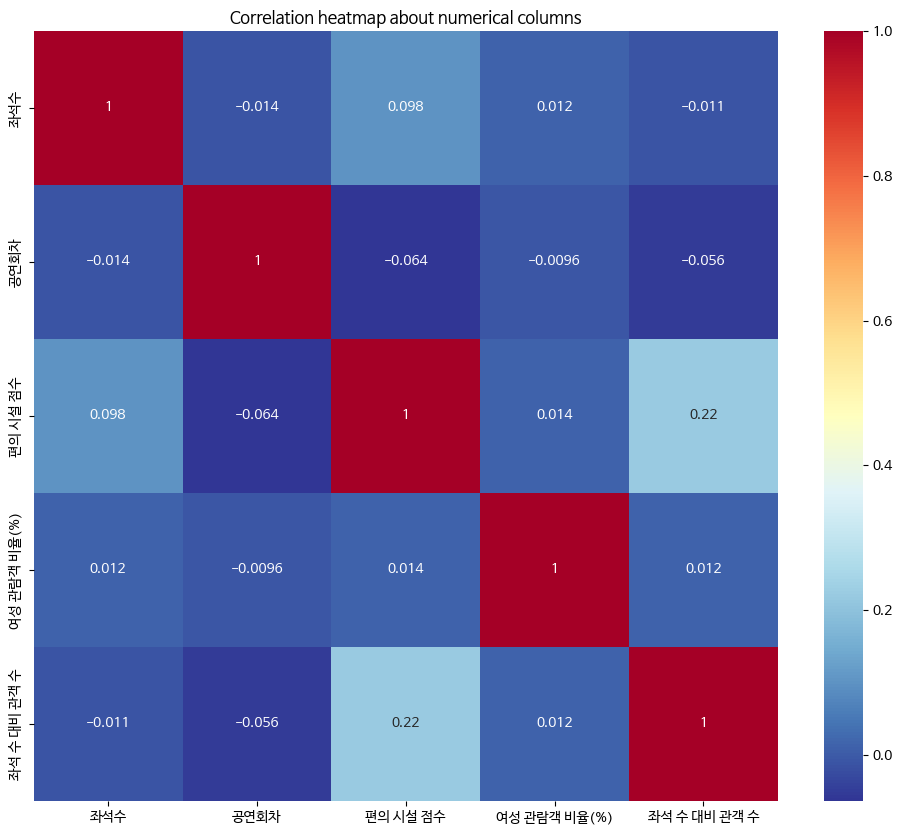

In [ ]:
plt.rc('font', family='NanumBarunGothic')

# 수치형 변수에 대한 상관계수 행렬 계산
corr_matrix_num = df_numerical.corr()

# 상관계수 행렬을 히트맵으로 그림
plt.figure(figsize=(12, 10))  # 히트맵 크기 설정
sns.heatmap(corr_matrix_num, annot=True, cmap='RdYlBu_r')  
plt.title("Correlation heatmap about numerical columns")
plt.show()

##### 범주형 변수

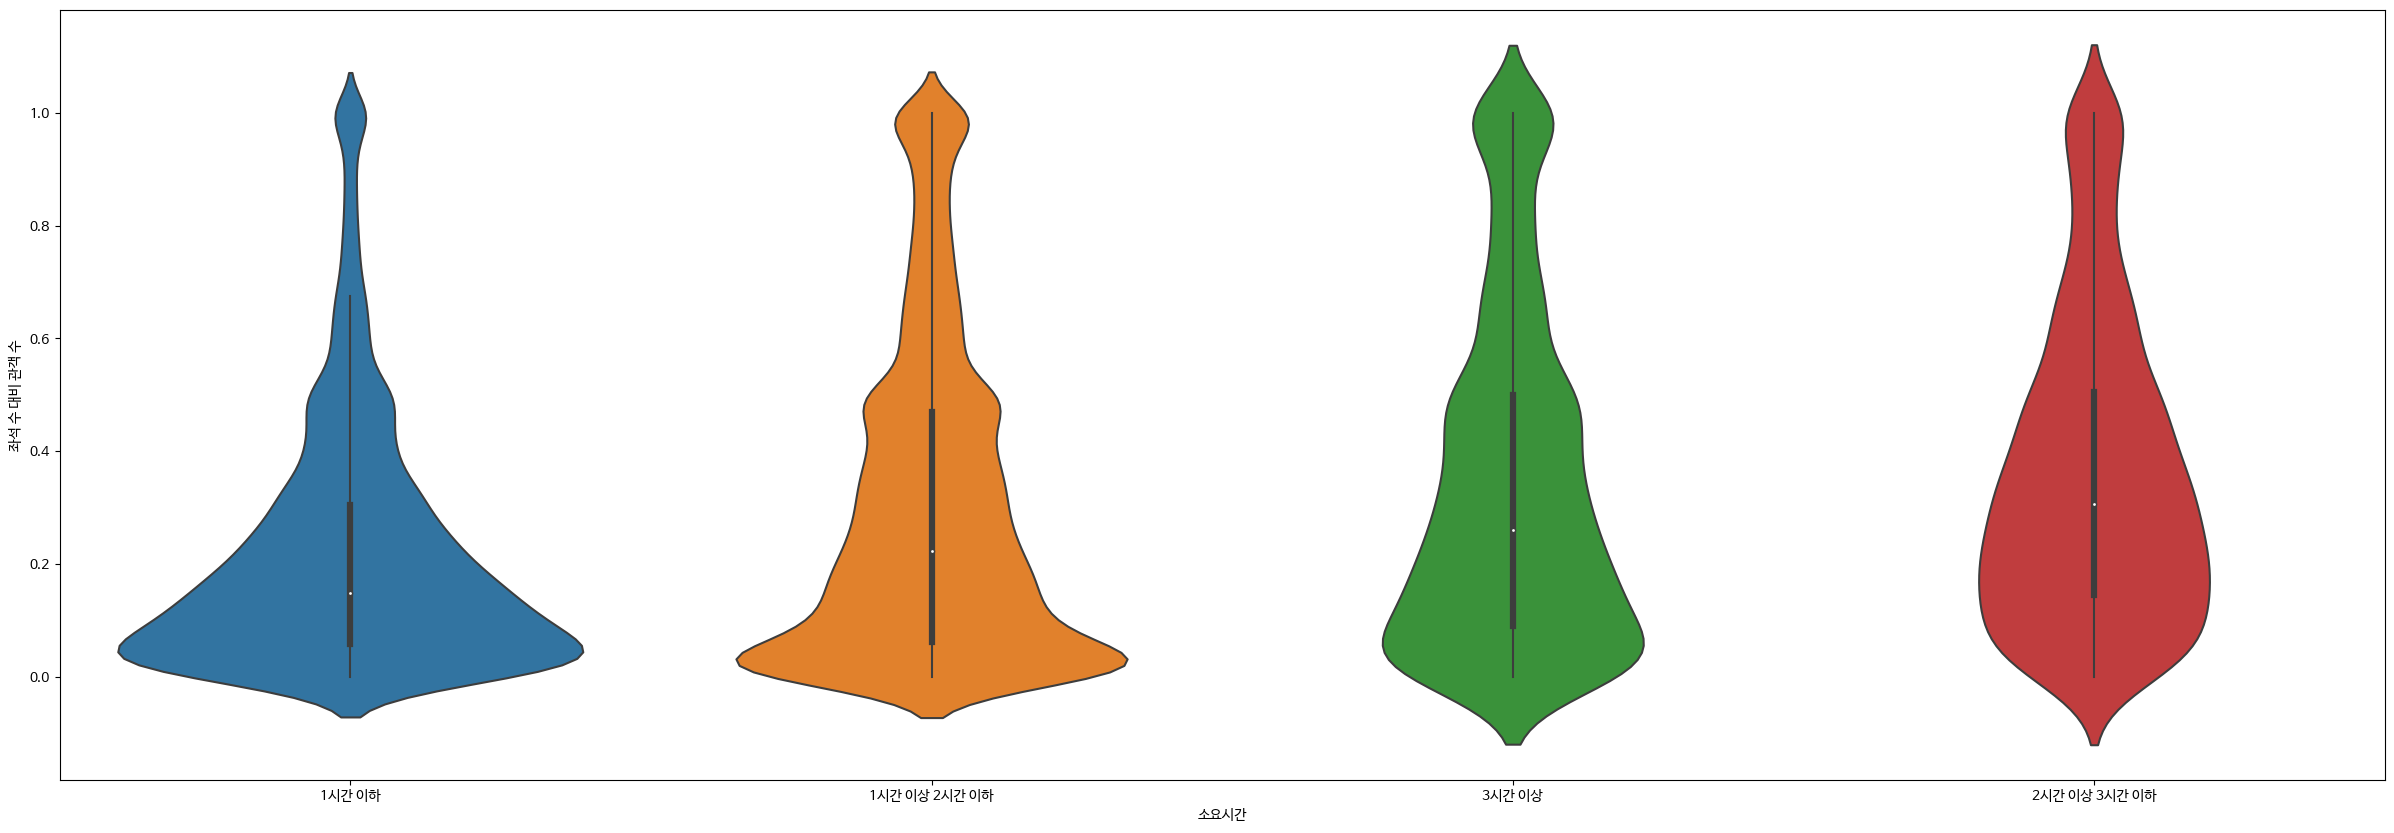

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


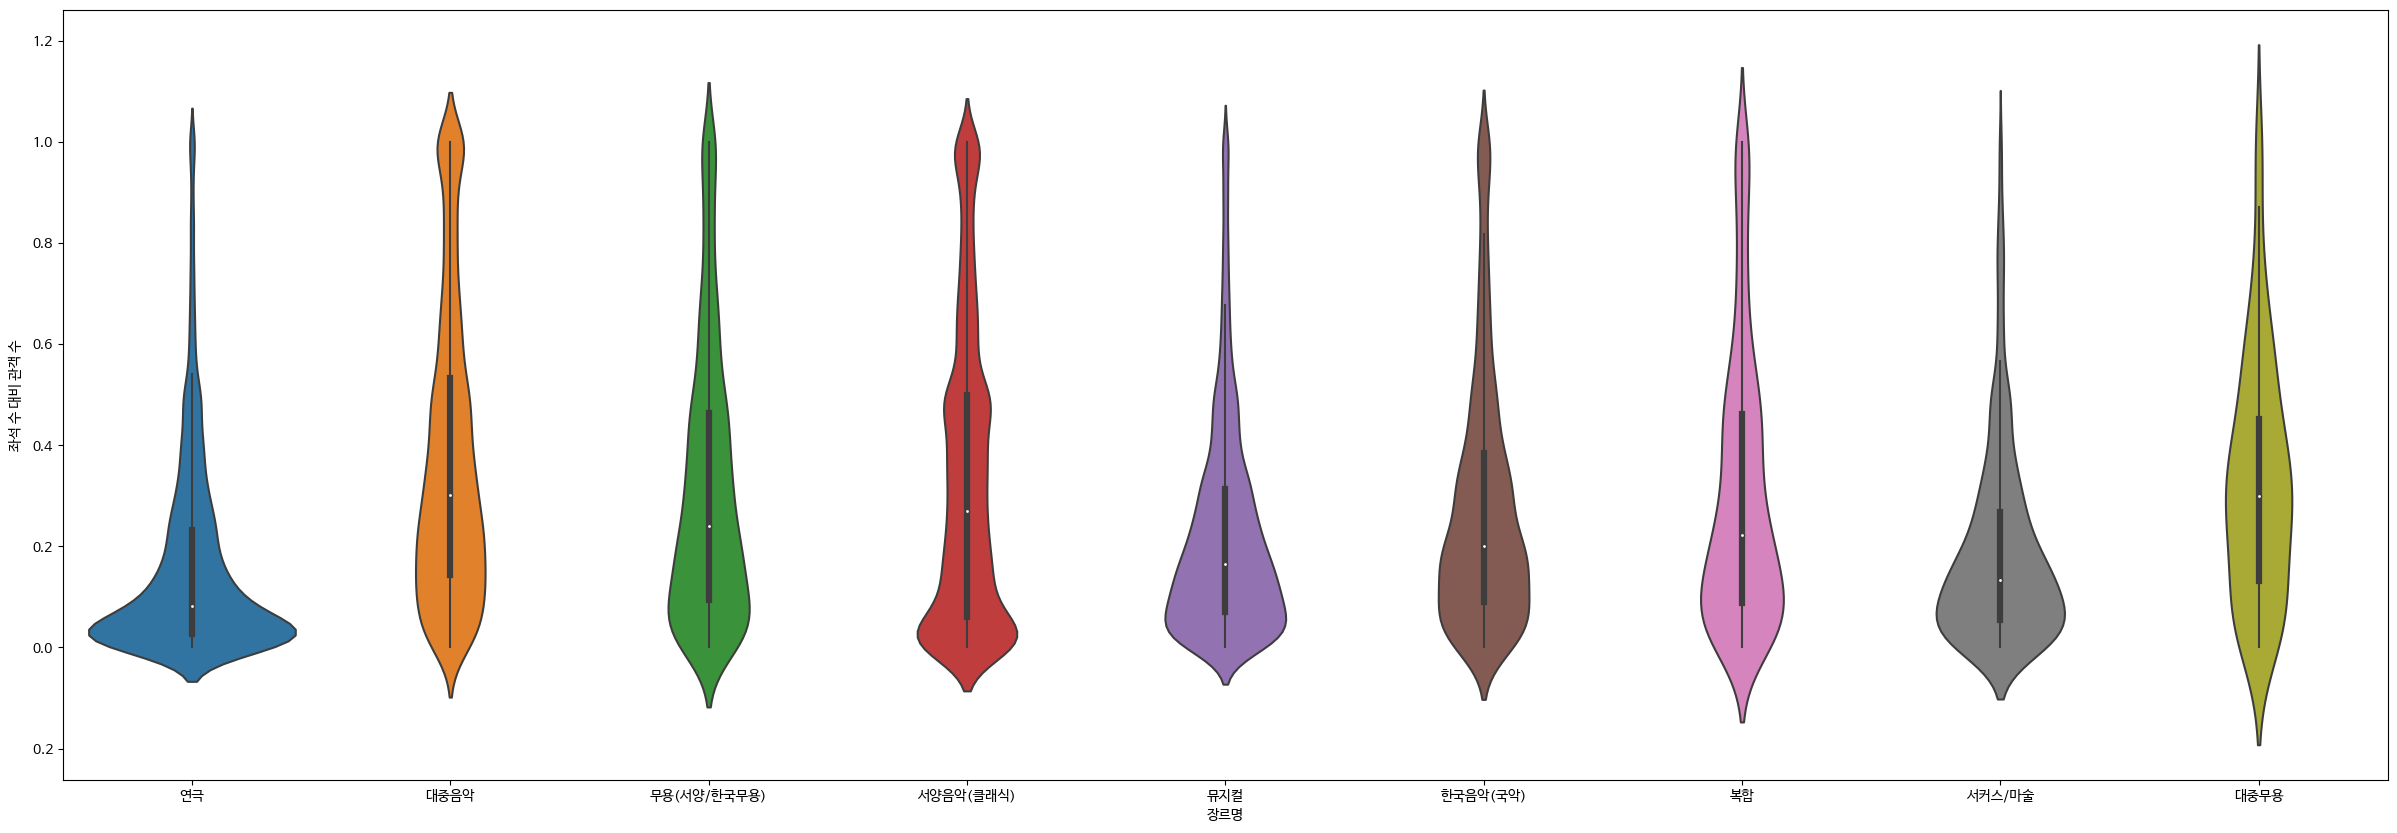

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


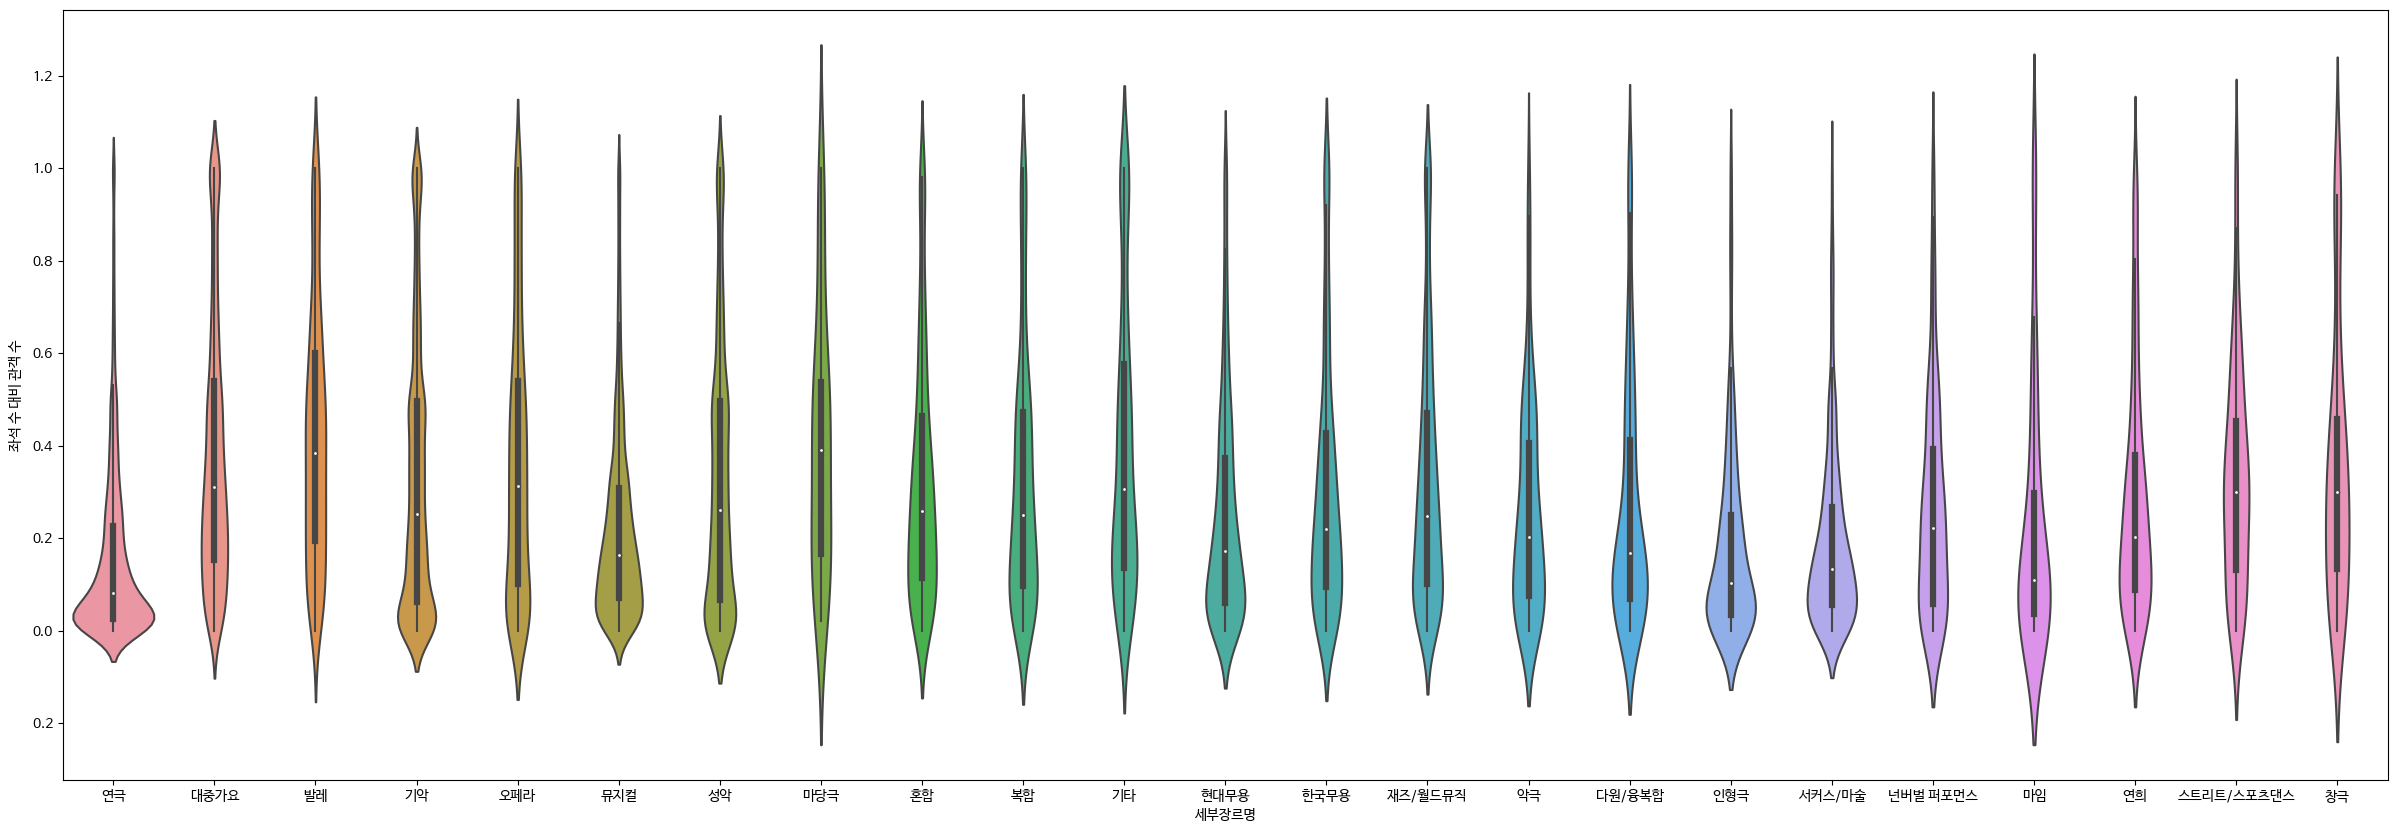

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


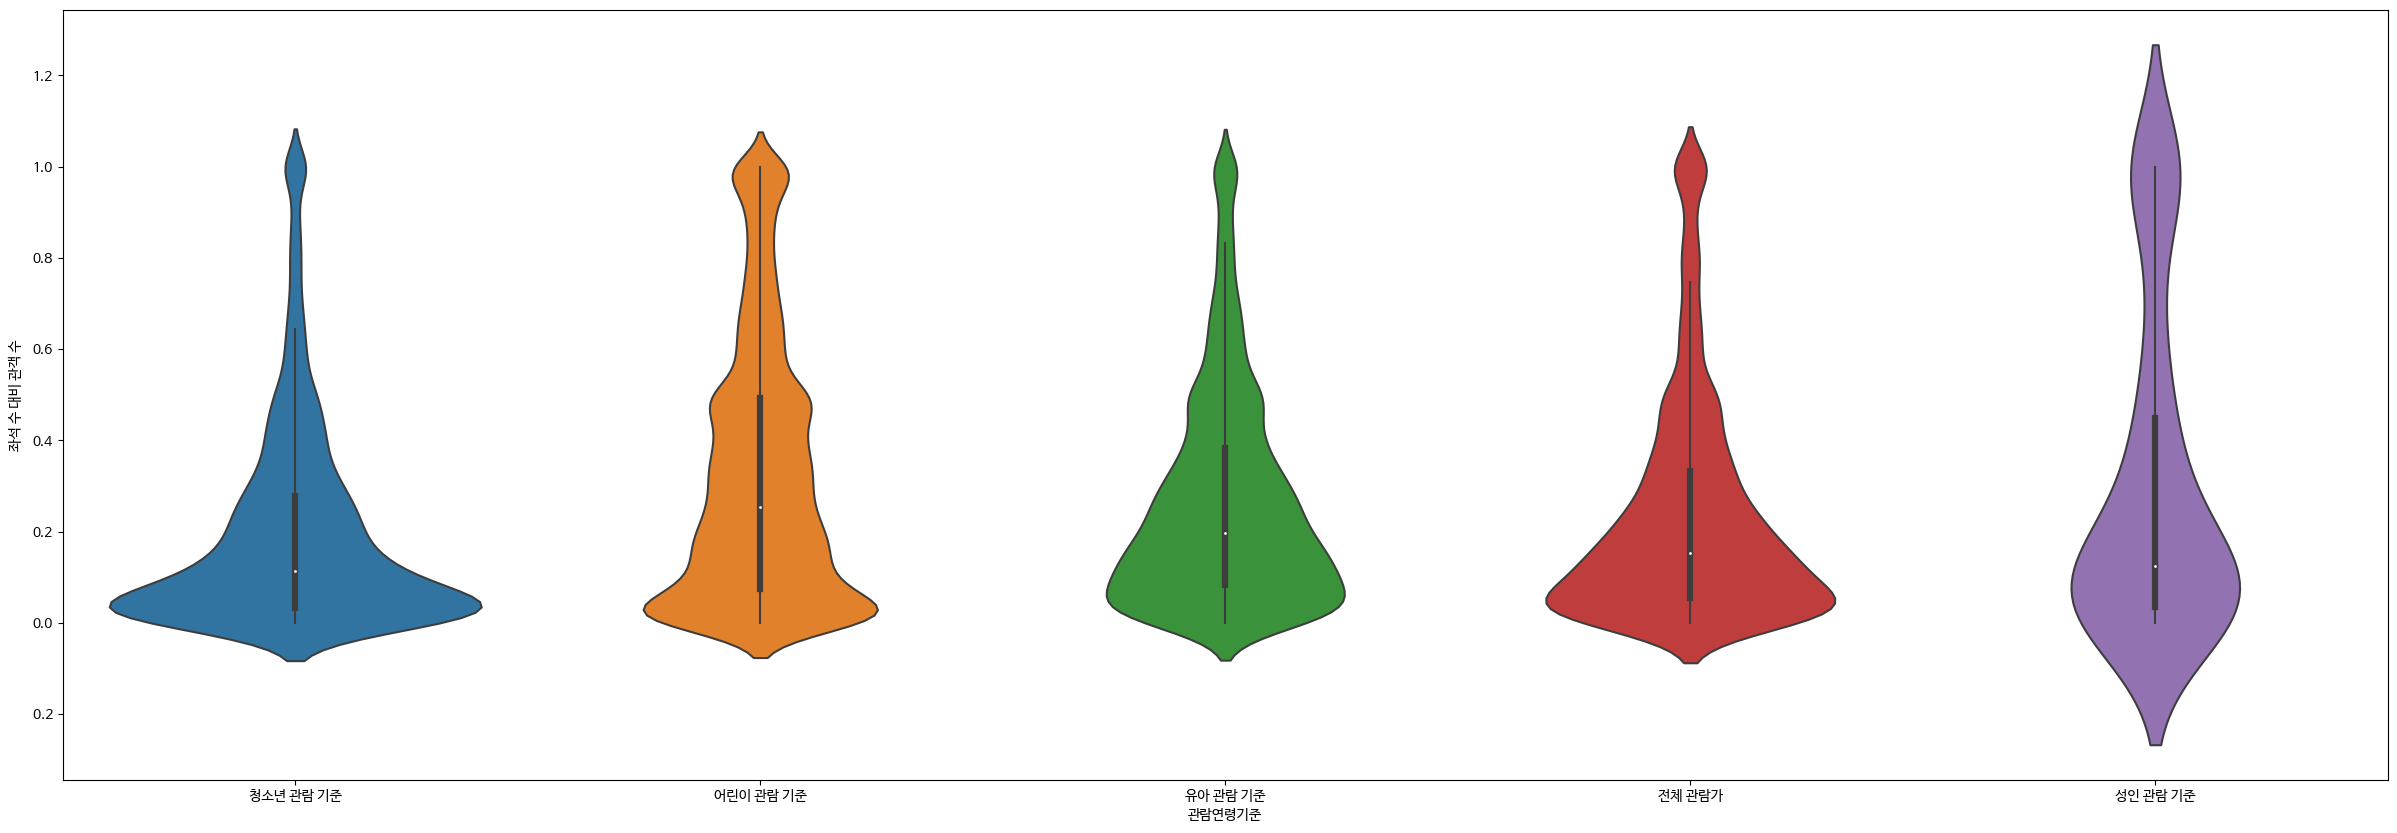

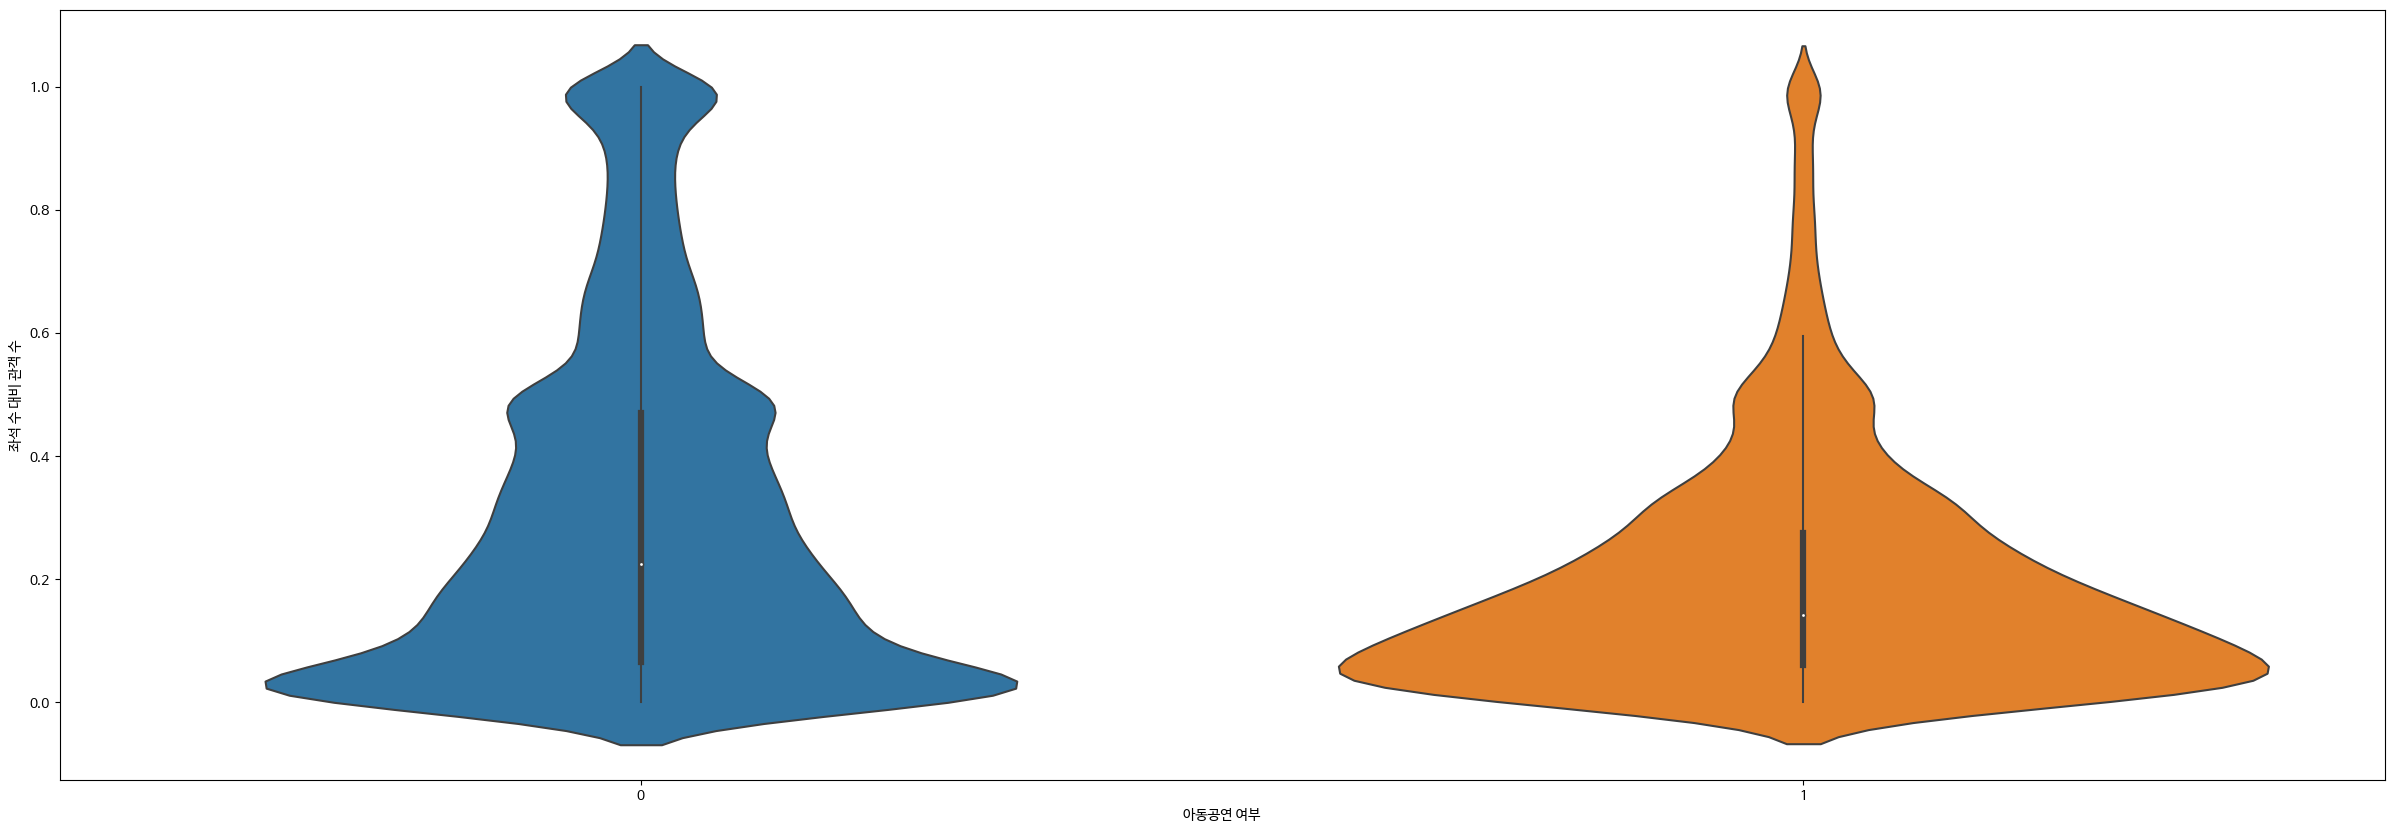

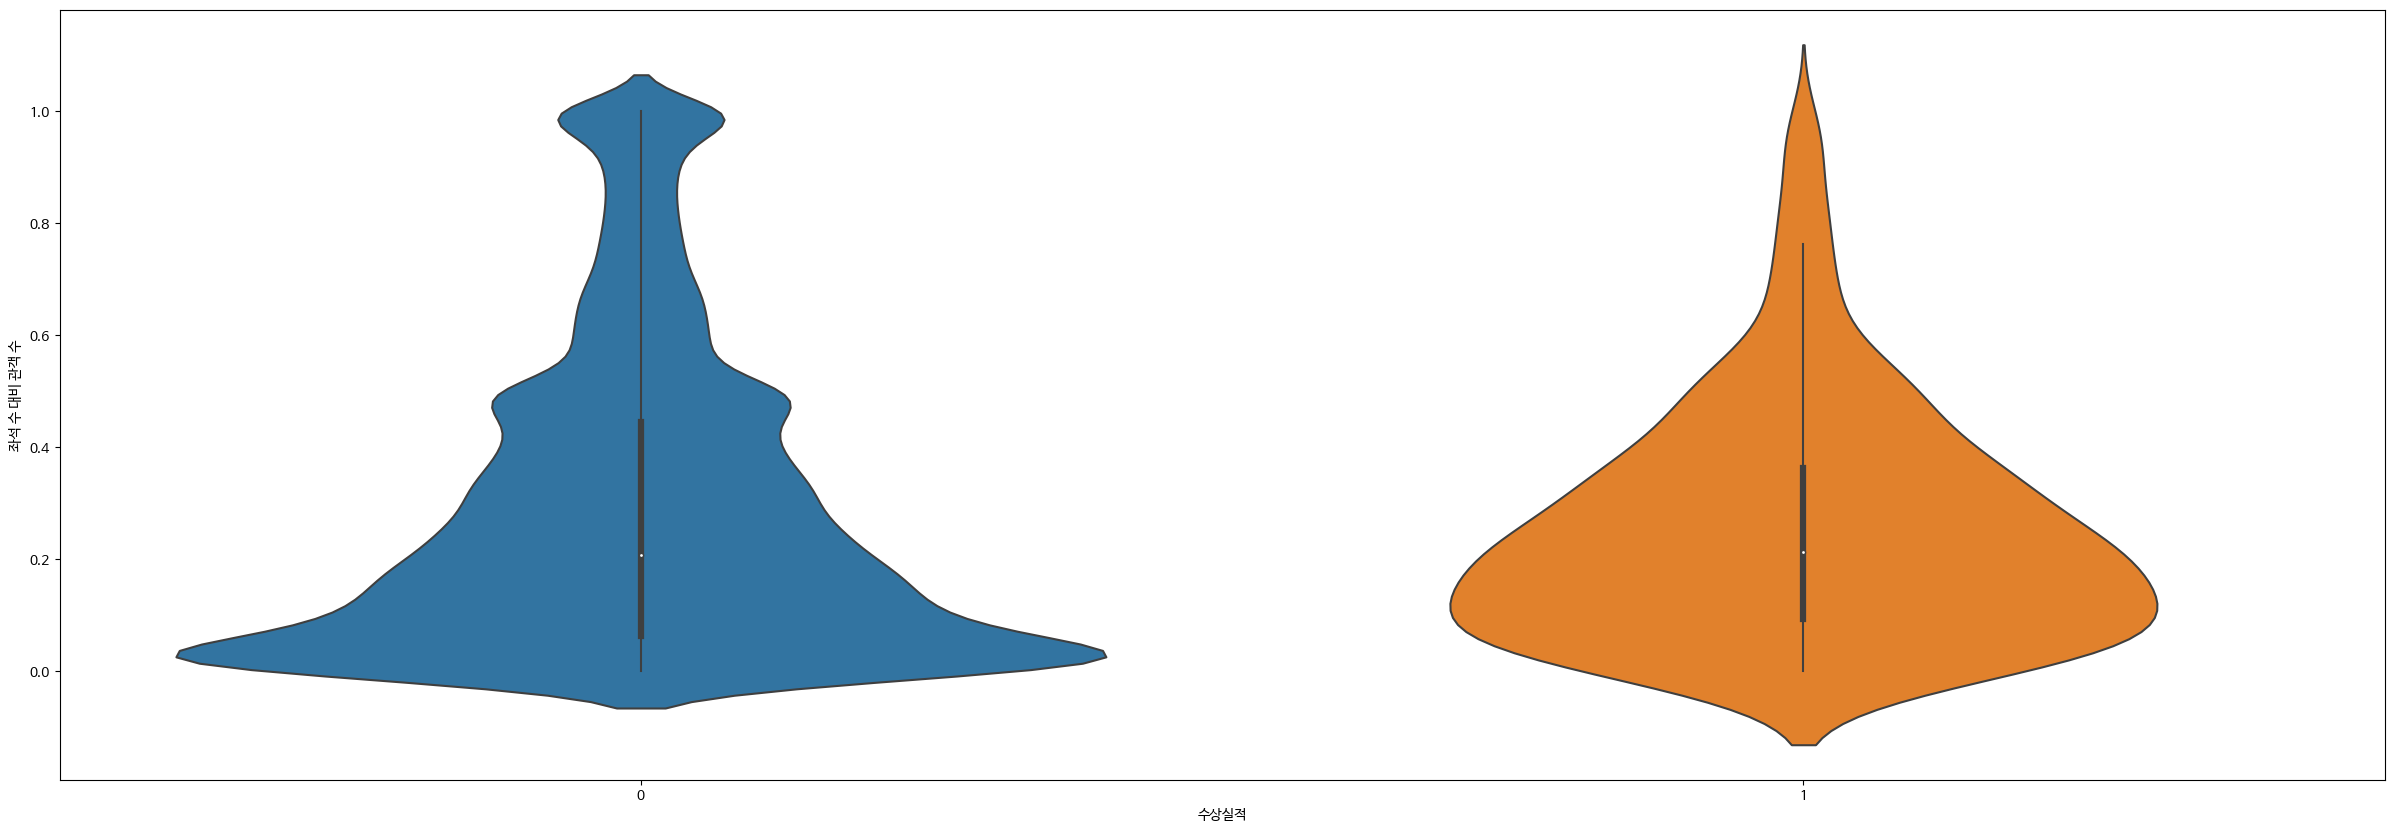

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


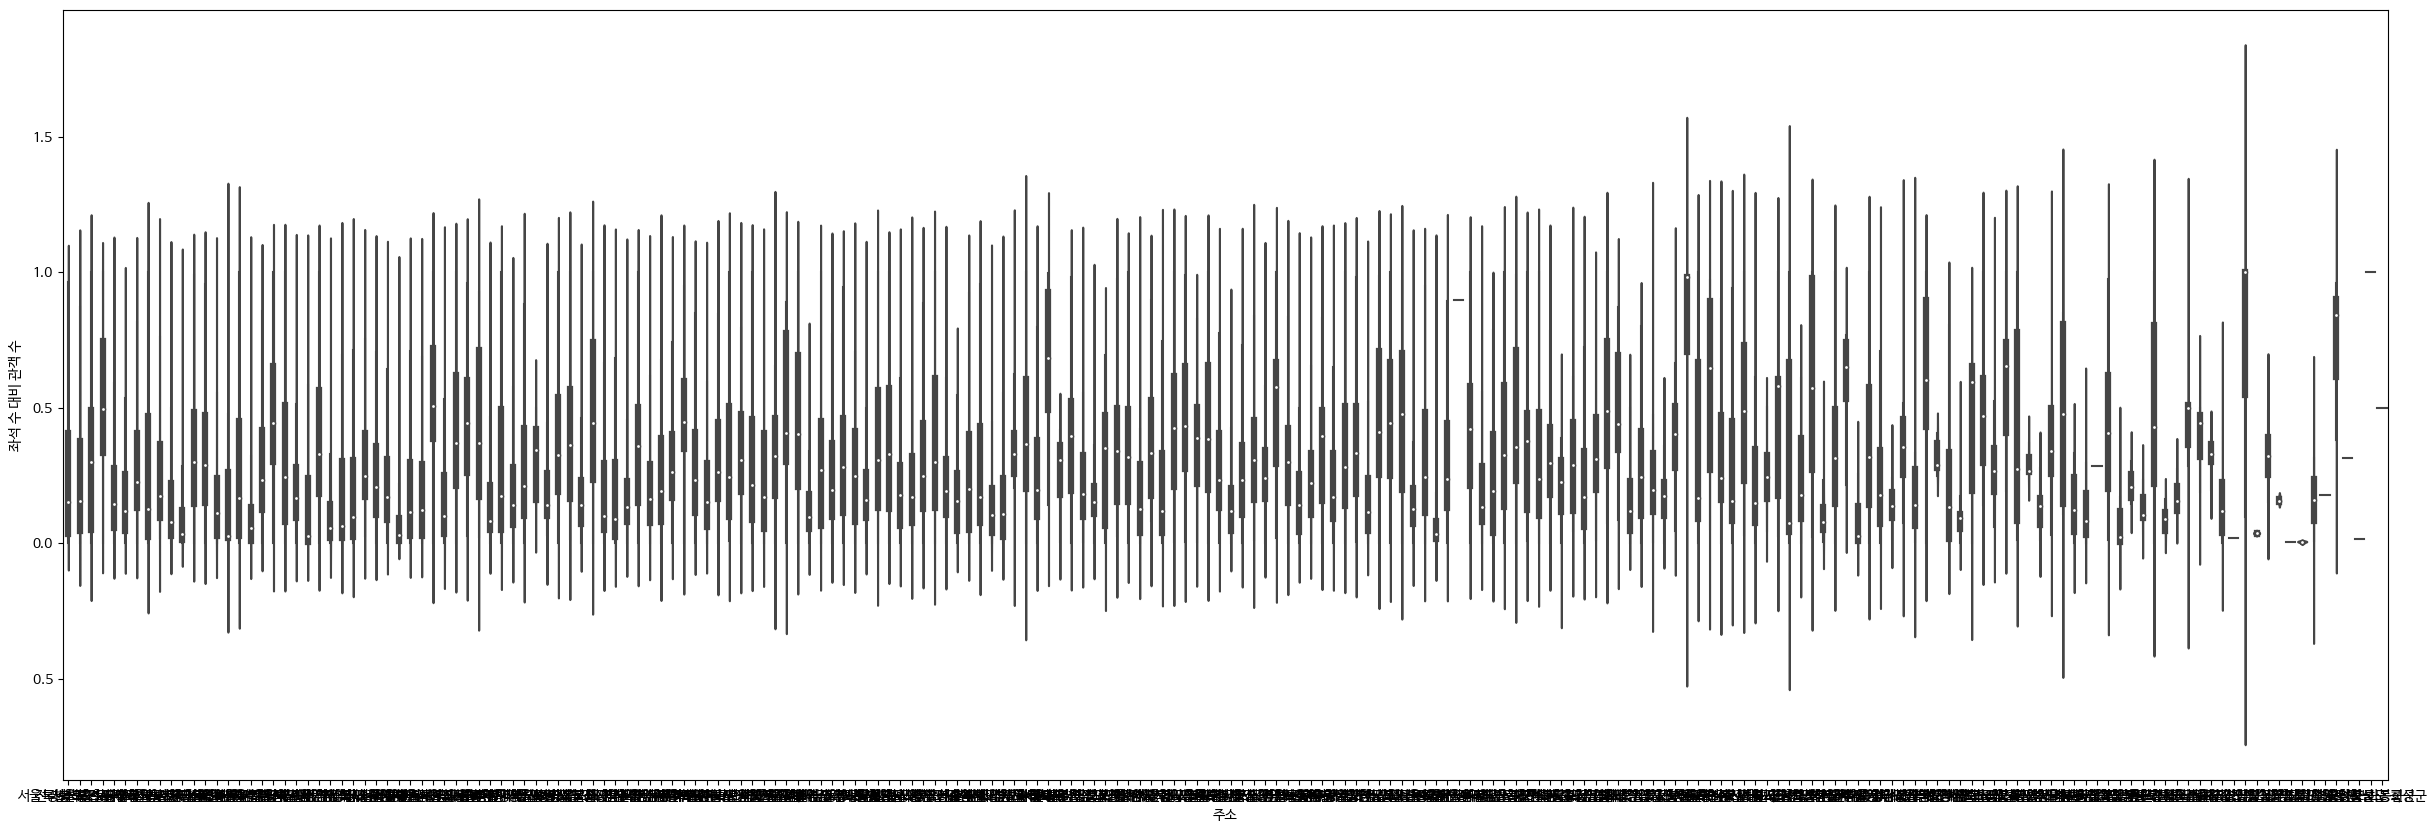

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


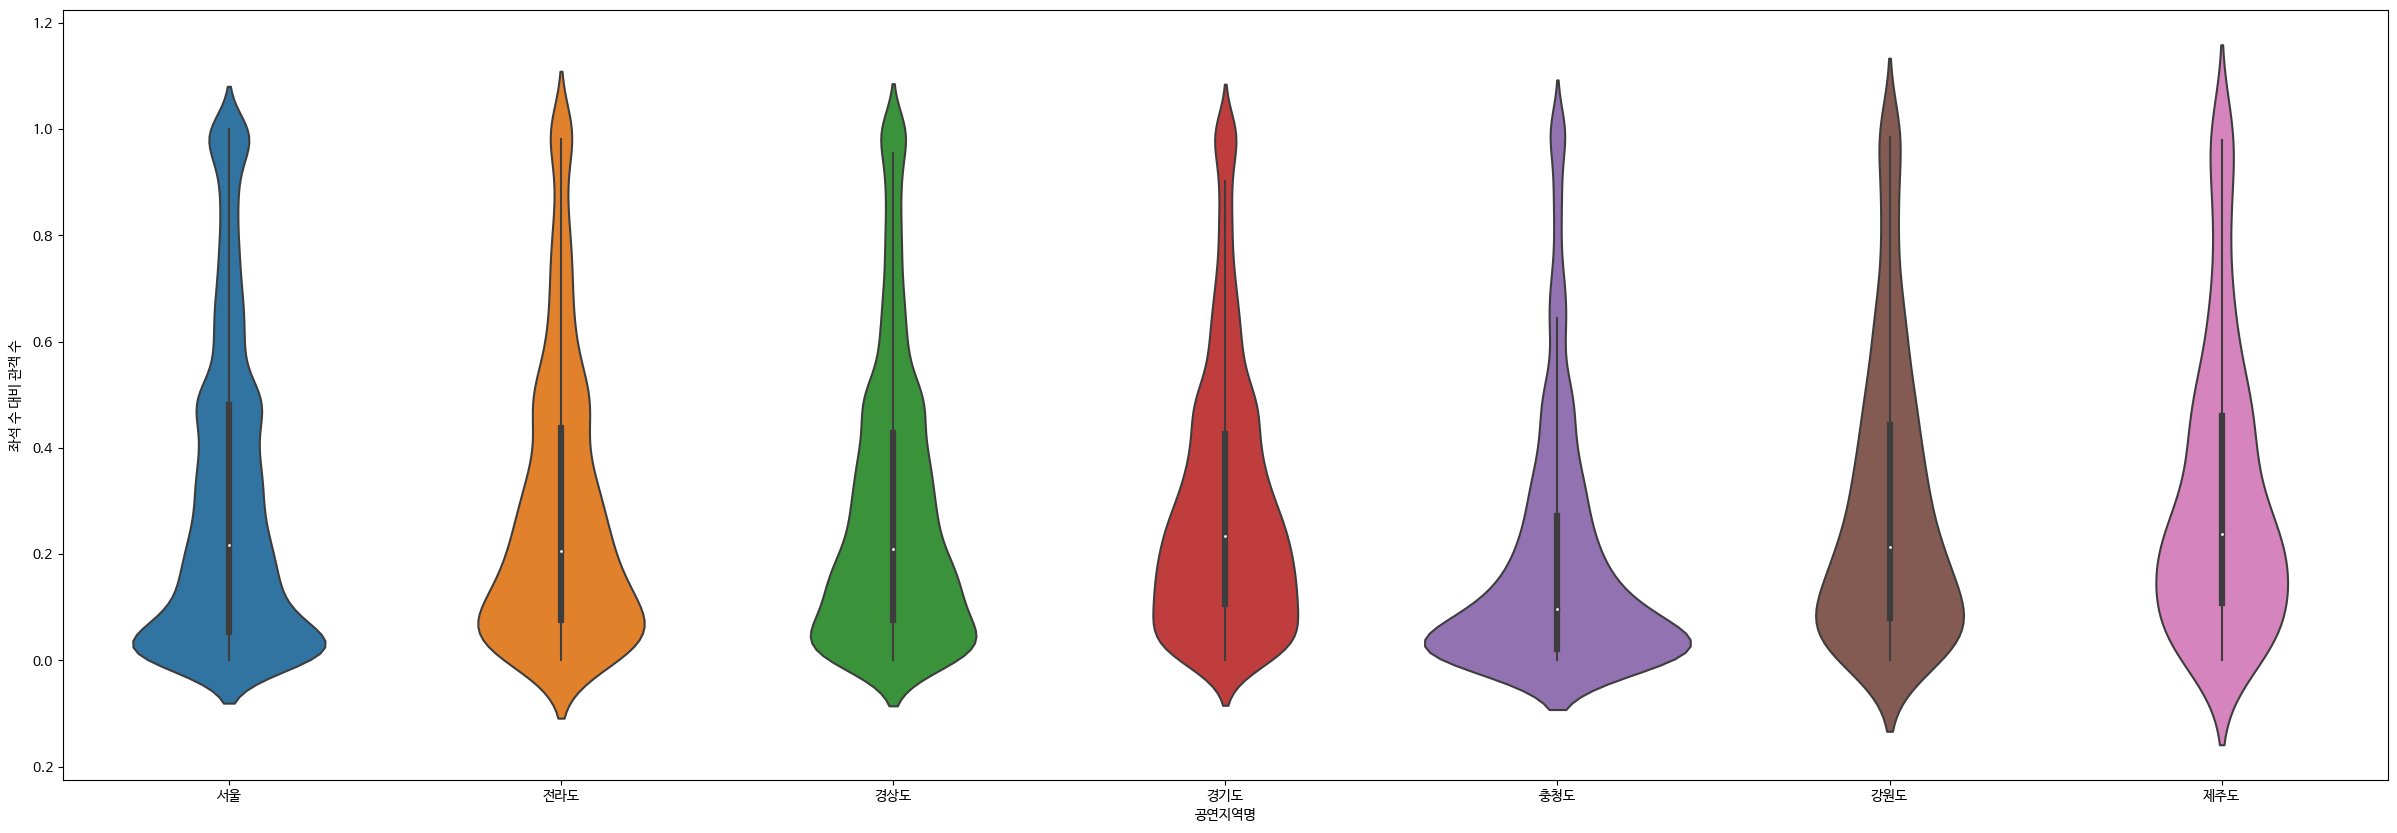

In [ ]:
# df_categorical의 각 범주형 변수에 대해 바이올린 플롯
for col in df_categorical.columns:
    plt.figure(figsize=(30,10))
    sns.violinplot(x=col, y='좌석 수 대비 관객 수', data=df_categorical)
    plt.show()

In [ ]:
# 범주형 인코딩 규칙
# - 고유 카테고리 수 ≤ 5: 원-핫 인코딩(필요 시 drop='first'로 다중공선성 완화)
# - 고유 카테고리 수 > 5: 타깃 평균 인코딩(누수 방지를 위해 OOF/스무딩 적용)

In [ ]:
few_cols  = ['소요시간', '관람연령기준']
many_cols = ['공연지역명', '주소', '장르명', '세부장르명']

df_few  = df_categorical.loc[:, few_cols].copy()
df_many = df_categorical.loc[:, many_cols].copy()
y = ml_df['좌석 수 대비 관객 수'].values

for c in many_cols:
    df_many[c] = df_many[c].astype('category')

encoded_few = pd.get_dummies(df_few, columns=few_cols, drop_first=True, dtype='uint8')

encoded_many = pd.DataFrame(
    {f'{c}_te': df_many.groupby(c)[pd.Series(y, index=df_many.index).name].transform('mean')
     for c in many_cols},
    index=df_many.index
)

encoded_df = pd.concat([encoded_many, encoded_few], axis=1)

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


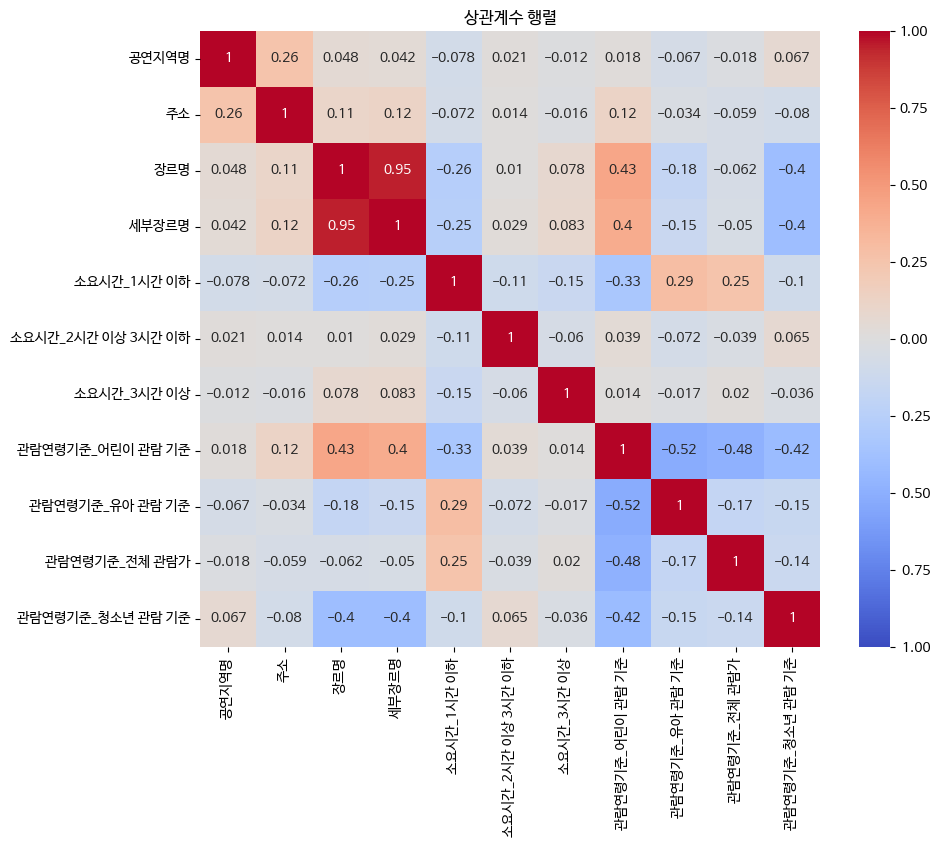

In [35]:
# 상관계수 행렬
corr_matrix_cat_target1 = encoded_df.drop('target', axis = 1).corr()

# 히트맵으로 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_cat_target1, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("상관계수 행렬")
plt.show()

# 인코딩 및 피쳐 선택
### 수치형 : '남성 관광객 비율' 제거, '편의 시설' 및 '장애인 시설' 하나로 합치기  
### 범주형 : '장르명' 제거

In [ ]:
ml_df['편의 시설 점수'] = ml_df['편의 시설 점수'].add(ml_df.pop('장애인 시설 점수'), fill_value=0)
ml_df.drop(columns=['남성 관람객 비율(%)', '장르명'], inplace=True) 
df_cat_en = encoded_df.drop(columns=['장르명', 'target'], errors='ignore')

full_enc_df = pd.concat([df_cat_en, df_numerical], axis=1, copy=False)

In [ ]:
# 데이터 분할

df = full_enc_df

X = df.drop('좌석 수 대비 관객 수', axis=1)
y = df['좌석 수 대비 관객 수']

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
# 모델1 : AdaBoost

model = AdaBoostRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE for AdaBoost:", mean_squared_error(y_test, y_pred))

MSE for AdaBoost: 0.06294731170762342


In [44]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE for GBM:", mean_squared_error(y_test, y_pred))

MSE for GBM: 0.047121234030048226


In [45]:
import xgboost as xgb

model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE for XGBoost:", mean_squared_error(y_test, y_pred))

MSE for XGBoost: 0.04145232072865606


In [46]:
import lightgbm as lgb

model = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE for LightGBM:", mean_squared_error(y_test, y_pred))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 29192, number of used features: 14
[LightGBM] [Info] Start training from score 0.289576
MSE for LightGBM: 0.04161377049561393


In [47]:
# catboost : 평균인코딩 부분을 catboost 내장 기능으로 대체
ml_df1 = ml_df.loc[:, ml_df.columns]
encoded_few = pd.get_dummies(ml_df1, columns = ['소요시간', '관람연령기준'], drop_first=True)

df = encoded_few

# Splitting data into train and test sets
X = df.drop('좌석 수 대비 관객 수', axis=1)
y = df['좌석 수 대비 관객 수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical columns
cat_features = ['주소', '세부장르명', '아동공연 여부', '수상실적', '공연지역명',
                '소요시간_1시간 이하', '소요시간_2시간 이상 3시간 이하', '소요시간_3시간 이상',
                '관람연령기준_어린이 관람 기준', '관람연령기준_유아 관람 기준', '관람연령기준_전체 관람가', '관람연령기준_청소년 관람 기준']

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, loss_function='RMSE', verbose=200)

# Train model
model.fit(X_train, y_train, cat_features=cat_features)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

0:	learn: 0.2696598	total: 78.7ms	remaining: 1m 18s
200:	learn: 0.2104674	total: 6.94s	remaining: 27.6s
400:	learn: 0.2036064	total: 11.5s	remaining: 17.1s
600:	learn: 0.1997965	total: 15.9s	remaining: 10.5s
800:	learn: 0.1964354	total: 22.7s	remaining: 5.65s
999:	learn: 0.1937242	total: 27.4s	remaining: 0us
Mean Squared Error: 0.0398


# 전체 원 핫 인코딩

In [48]:
ml_df.columns

Index(['편의 시설 점수', '공연회차', '소요시간', '세부장르명', '여성 관람객 비율(%)', '관람연령기준',
       '아동공연 여부', '수상실적', '주소', '공연지역명', '좌석수', '좌석 수 대비 관객 수'],
      dtype='object')

In [49]:
total_column = list(ml_df.columns)
num_column = ['좌석수', '공연회차', '편의 시설 점수', '여성 관람객 비율(%)', '좌석 수 대비 관객 수']
cat_column = [item for item in total_column if item not in num_column]

In [50]:
# One-hot encode using pandas
ml_allonehot = pd.get_dummies(ml_df, columns = cat_column, drop_first=True)

In [51]:
ml_allonehot.head()

,편의 시설 점수,공연회차,여성 관람객 비율(%),좌석수,좌석 수 대비 관객 수,소요시간_1시간 이하,소요시간_2시간 이상 3시간 이하,소요시간_3시간 이상,세부장르명_기타,세부장르명_넌버벌 퍼포먼스,...,주소_충청북도 증평군,주소_충청북도 진천군,주소_충청북도 청주시,주소_충청북도 충주시,공연지역명_경기도,공연지역명_경상도,공연지역명_서울,공연지역명_전라도,공연지역명_제주도,공연지역명_충청도
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
PF382001,0,3,68.4,70,0.085714,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
PF382534,7,1,80.0,2037,0.627884,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
PF311997,5,1,82.9,667,0.701649,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
PF393258,9,1,83.6,354,0.327684,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
PF398699,3,1,100.0,1041,0.162344,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [52]:
df = ml_allonehot

# Splitting data into features and target
X = df.drop('좌석 수 대비 관객 수', axis=1)
y = df['좌석 수 대비 관객 수']

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [53]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

model = AdaBoostRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE for AdaBoost:", mean_squared_error(y_test, y_pred))

MSE for AdaBoost: 0.06837060055834193


In [54]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE for GBM:", mean_squared_error(y_test, y_pred))

MSE for GBM: 0.049708751233801106


In [55]:
import xgboost as xgb

model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE for XGBoost:", mean_squared_error(y_test, y_pred))

MSE for XGBoost: 0.044445124456568424


In [56]:
import lightgbm as lgb

model = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MSE for LightGBM:", mean_squared_error(y_test, y_pred))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 29192, number of used features: 178
[LightGBM] [Info] Start training from score 0.289576
MSE for LightGBM: 0.04228499172257957


In [57]:
# Catboost
total_column1 = list(ml_allonehot.columns)
num_column = num_column
cat_column1 = [item for item in total_column1 if item not in num_column]

df = ml_allonehot

# Splitting data into train and test sets
X = df.drop('좌석 수 대비 관객 수', axis=1)
y = df['좌석 수 대비 관객 수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical columns
cat_features = cat_column1

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, loss_function='RMSE', verbose=200)

# Train model
model.fit(X_train, y_train, cat_features=cat_features)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

0:	learn: 0.2704952	total: 7.35ms	remaining: 7.34s
200:	learn: 0.2161215	total: 1.32s	remaining: 5.25s
400:	learn: 0.2069657	total: 2.56s	remaining: 3.82s
600:	learn: 0.2014082	total: 4.68s	remaining: 3.11s
800:	learn: 0.1974260	total: 7.54s	remaining: 1.87s
999:	learn: 0.1942774	total: 8.77s	remaining: 0us
Mean Squared Error: 0.0406


# 최종적으로 부분 one-hot encoding + catboost 이용

In [58]:
ml_df.head(1)

,편의 시설 점수,공연회차,소요시간,세부장르명,여성 관람객 비율(%),관람연령기준,아동공연 여부,수상실적,주소,공연지역명,좌석수,좌석 수 대비 관객 수
Unnamed: 0,,,,,,,,,,,,
PF382001,0,3,1시간 이하,연극,68.4,청소년 관람 기준,0,0,서울특별시 종로구,서울,70,0.085714


In [59]:
ml_df_final = ml_df.loc[:, ml_df.columns]

In [60]:
encoded_final = pd.get_dummies(ml_df_final, columns = ['소요시간', '관람연령기준', '공연지역명'], drop_first=True)

In [61]:
encoded_final.head(1)

,편의 시설 점수,공연회차,세부장르명,여성 관람객 비율(%),아동공연 여부,수상실적,주소,좌석수,좌석 수 대비 관객 수,소요시간_1시간 이하,...,관람연령기준_어린이 관람 기준,관람연령기준_유아 관람 기준,관람연령기준_전체 관람가,관람연령기준_청소년 관람 기준,공연지역명_경기도,공연지역명_경상도,공연지역명_서울,공연지역명_전라도,공연지역명_제주도,공연지역명_충청도
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
PF382001,0,3,연극,68.4,0,0,서울특별시 종로구,70,0.085714,1,...,0,0,0,1,0,0,1,0,0,0


In [62]:
numerical_columns = ['좌석수', '공연회차', '편의 시설 점수', '여성 관람객 비율(%)', '좌석 수 대비 관객 수']
catl_columns = [item for item in encoded_final.columns if item not in numerical_columns]

In [63]:
df = encoded_final

# Splitting data into train and test sets
X = df.drop('좌석 수 대비 관객 수', axis=1)
y = df['좌석 수 대비 관객 수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical columns
cat_features = catl_columns

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, loss_function='RMSE', verbose=200)

# Train model
model.fit(X_train, y_train, cat_features=cat_features)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

0:	learn: 0.2697140	total: 20.8ms	remaining: 20.8s
200:	learn: 0.2105883	total: 3.69s	remaining: 14.7s
400:	learn: 0.2033500	total: 7.36s	remaining: 11s
600:	learn: 0.1989297	total: 13.3s	remaining: 8.8s
800:	learn: 0.1954097	total: 16.9s	remaining: 4.19s
999:	learn: 0.1926341	total: 20.5s	remaining: 0us
Mean Squared Error: 0.0396


# 머신러닝 결과값 정리

In [64]:
encoded_few = pd.get_dummies(ml_df, columns = ['소요시간', '관람연령기준', '공연지역명'], drop_first=True)

encoded_few_ml = encoded_few.drop('좌석 수 대비 관객 수', axis=1)

In [65]:
predict_dict = {}

for i in encoded_few_ml.index:
    predict = model.predict(encoded_few_ml.loc[i])
    predict_dict[i] = predict

In [66]:
ml_df['예측값'] = ml_df.index.map(lambda x: predict_dict.get(x, x))

In [67]:
ml_df.head()

,편의 시설 점수,공연회차,소요시간,세부장르명,여성 관람객 비율(%),관람연령기준,아동공연 여부,수상실적,주소,공연지역명,좌석수,좌석 수 대비 관객 수,예측값
Unnamed: 0,,,,,,,,,,,,,
PF382001,0,3,1시간 이하,연극,68.4,청소년 관람 기준,0,0,서울특별시 종로구,서울,70,0.085714,0.187927
PF382534,7,1,1시간 이상 2시간 이하,대중가요,80.0,어린이 관람 기준,0,0,전라북도 전주시,전라도,2037,0.627884,0.448565
PF311997,5,1,1시간 이상 2시간 이하,발레,82.9,유아 관람 기준,0,0,경상북도 구미시,경상도,667,0.701649,0.544918
PF393258,9,1,1시간 이상 2시간 이하,기악,83.6,어린이 관람 기준,0,0,서울특별시 서초구,서울,354,0.327684,0.628543
PF398699,3,1,3시간 이상,기악,100.0,유아 관람 기준,0,0,경기도 부천시,경기도,1041,0.162344,0.284178


In [68]:
ml_df_result = ml_df[['좌석 수 대비 관객 수', '예측값']]

In [ ]:
#본선/2차_전처리/ml_df_result.xlsx
from google.colab import files
uploaded = files.upload()

In [ ]:
ml_df_result.to_excel('본선/2차_전처리/ml_df_result.xlsx')

In [74]:
ml_df_result.head()

,좌석 수 대비 관객 수,예측값
Unnamed: 0,,
PF382001,0.085714,0.187927
PF382534,0.627884,0.448565
PF311997,0.701649,0.544918
PF393258,0.327684,0.628543
PF398699,0.162344,0.284178


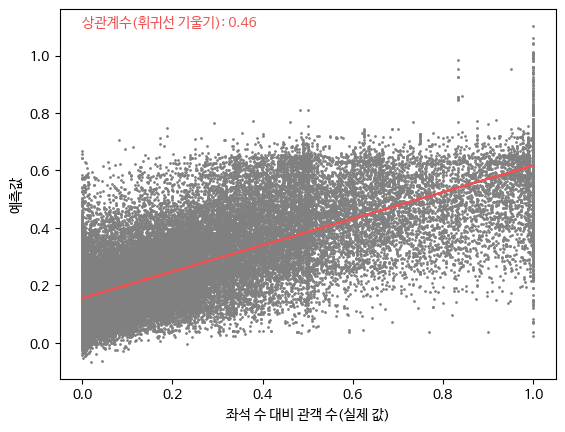

In [74]:
#한글깨짐방지
plt.rc('font', family='NanumBarunGothic')

import matplotlib.pyplot as plt
import numpy as np

df = ml_df_result

# 데이터
x = df['좌석 수 대비 관객 수']
y = df['예측값']

# 선형 회귀 계수 계산
m, b = np.polyfit(x, y, 1)

# 산점도
plt.scatter(x, y, s=1, color='grey')

# 선형 회귀 선
plt.plot(x, m*x + b, color='#EE5353')

plt.text(min(x), max(y), f'상관계수(휘귀선 기울기): {m:.2f}', fontsize=10, color='#EE5353')

plt.xlabel('좌석 수 대비 관객 수(실제 값)')
plt.ylabel('예측값')
# plt.title('좌석 수 대비 관객 수 vs 예측값 with Regression Line')
plt.show()


# 사용자 이용 메커니즘

In [ ]:
def user_input(seat, convenience, sex_ratio):
    hour_list = list(set(ml_df['소요시간']))
    genre_list = list(set(ml_df['세부장르명']))
    age_list = list(set(ml_df['관람연령기준']))
    address_list = list(set(ml_df['주소']))
    region_list = list(set(ml_df['공연지역명']))
    yn_list = ['Y', 'N']

    show_count = int(input('희망 공연 회차 : '))
    hour = input(f'예상 소요시간_{tuple(hour_list)}중 선택 : ')
    genre = input(f'공연장르_{tuple(genre_list)}중 선택 : ')
    age = input(f'관람연령기준_{tuple(age_list)}중 선택 : ')
    child = input(f'아동공연여부_{tuple(yn_list)}중 선택 : ')
    prize = input(f'수상실적여부_{tuple(yn_list)}중 선택 : ')
    address = input(f'주소 : ')
    region = input(f'공연지역_{tuple(region_list)}중 선택 : ')

    seat = seat
    convenience = convenience
    sex_ratio = sex_ratio

    input_dict =  {'편의 시설 점수' : convenience,
                   '공연회차' : show_count,
                   '소요시간' : hour,
                   '세부장르명' : genre,
                   '여성 관람객 비율(%)' : sex_ratio,
                   '관람연령기준' : age,
                   '아동공연 여부' : child,
                   '수상실적' : prize, # N,Y 선택
                   '주소' : address,
                   '공연지역명' : region, # 리스트에서 선택
                   '좌석수' : 3} # 공연 데이터에서 값 반환

    array = pd.DataFrame([input_dict])

    cat_column = ['소요시간', '관람연령기준', '공연지역명']
    bin_col = ['아동공연 여부', '수상실적']

    encoded_dict = {}
    for c in list(array.columns):
        if c in cat_column:
            encoded_dict[c + '_' + list(array[c])[0]] = 1
        else : encoded_dict[c] = list(array[c])[0]
        if c in bin_col:
            if list(array[c])[0] == 'Y':
                encoded_dict[c] = 1
            else : encoded_dict[c] = 0

    empty_df_ml = pd.DataFrame([dict(zip(encoded_final.columns, [0]*len(encoded_final.columns)))])
    empty_df_ml = empty_df_ml.drop('좌석 수 대비 관객 수', axis = 1)

    for c in empty_df_ml.columns:
        for k,v in encoded_dict.items():
            if c == k:
                empty_df_ml.loc[0, c] = v


    return empty_df_ml

In [ ]:
region_dict = {'FC224640-01' : [197, 1, 0.495526], 'FC224116-01' : [136, 0, 0.495526]}
# 경상남도 의령 : 3시간 이상, 청소년, 대중가요 - 1개, 목표 관객 수 : 1000명
# 전라남도 나주 : 1시간 이상 2시간 이하, 유아, 뮤지컬 - 3개, 목표 관객 수 : 500명
# 'FC222463-01' : [354, 3, 0.505276], 'hall_196' : [548, 0, 0.495526],



In [ ]:
hour_list = list(set(ml_df['소요시간']))
genre_list = list(set(ml_df['세부장르명']))
age_list = list(set(ml_df['관람연령기준']))
address_list = list(set(ml_df['주소']))
region_list = list(set(ml_df['공연지역명']))

In [ ]:
region_list

['제주도', '서울', '전라도', '강원도', '경기도', '충청도', '경상도']

In [ ]:
ml_result_dict = {}
for k in region_dict.keys():
    r = region_dict[k]
    seat = r[0]
    ml_value = model.predict(user_input(r[0], r[1], r[2]))

    ml_result_dict[k] = [seat, ml_value]

희망 공연 회차 : 2
예상 소요시간_('2시간 이상 3시간 이하', '3시간 이상', '1시간 이상 2시간 이하', '1시간 이하')중 선택 : 1시간 이상 2시간 이하
공연장르_('한국무용', '오페라', '마임', '대중가요', '인형극', '마당극', '연극', '연희', '성악', '재즈/월드뮤직', '창극', '발레', '복합', '혼합', '넌버벌 퍼포먼스', '기타', '현대무용', '뮤지컬', '다원/융복합', '기악', '악극', '스트리트/스포츠댄스', '서커스/마술')중 선택 : 뮤지컬
관람연령기준_('전체 관람가', '어린이 관람 기준', '유아 관람 기준', '청소년 관람 기준', '성인 관람 기준')중 선택 : 유아 관람 기준
아동공연여부_('Y', 'N')중 선택 : Y
수상실적여부_('Y', 'N')중 선택 : N
주소 : 전라남도 나주시
공연지역_('전라도', '서울', '경상도', '강원도', '충청도', '제주도', '경기도')중 선택 : 전라도
희망 공연 회차 : 2
예상 소요시간_('2시간 이상 3시간 이하', '3시간 이상', '1시간 이상 2시간 이하', '1시간 이하')중 선택 : 1시간 이상 2시간 이하
공연장르_('한국무용', '오페라', '마임', '대중가요', '인형극', '마당극', '연극', '연희', '성악', '재즈/월드뮤직', '창극', '발레', '복합', '혼합', '넌버벌 퍼포먼스', '기타', '현대무용', '뮤지컬', '다원/융복합', '기악', '악극', '스트리트/스포츠댄스', '서커스/마술')중 선택 : 뮤지컬
관람연령기준_('전체 관람가', '어린이 관람 기준', '유아 관람 기준', '청소년 관람 기준', '성인 관람 기준')중 선택 : 유아 관람 기준
아동공연여부_('Y', 'N')중 선택 : Y
수상실적여부_('Y', 'N')중 선택 : N
주소 : 전라남도 나주시
공연지역_('전라도', '서울', '경상도', '강원도', '충청도', '제주도', '경기도')중 선택 : 전라도


In [ ]:
ml_result_dict

{'FC224640-01': [197, array([0.59540314])],
 'FC224116-01': [136, array([0.57888127])]}

In [ ]:
1시간 이상 2시간 이하, 뮤지컬, 유아 관람 기준, 아동공연 Y, 수상실적 N, 전라남도 나주시, 전라도

In [ ]:
user_input(r[0], r[1], r[2])[1][0]

KeyboardInterrupt: ignored

In [ ]:
filtered_df = ml_df[
    (ml_df['소요시간'] == user_input(r[0], r[1], r[2])[1][0]) &
    (ml_df['세부장르명'] == user_input(r[0], r[1], r[2])[1][1]) &
    (ml_df['주소'] == user_input(r[0], r[1], r[2])[1][2])
]

KeyboardInterrupt: ignored

In [ ]:
filtered_df

,편의 시설 점수,공연회차,소요시간,세부장르명,여성 관람객 비율(%),관람연령기준,아동공연 여부,수상실적,주소,공연지역명,좌석수,좌석 수 대비 관객 수,예측값
Unnamed: 0,,,,,,,,,,,,,
PF395391,3,1,3시간 이상,대중가요,100.0,어린이 관람 기준,0,0,경상남도 의령군,경상도,354,0.491525,0.59301
PF380068,3,1,3시간 이상,대중가요,100.0,어린이 관람 기준,0,0,경상남도 의령군,경상도,354,0.423729,0.59301
PF313806,3,1,3시간 이상,대중가요,100.0,어린이 관람 기준,0,0,경상남도 의령군,경상도,354,1.000000,0.59301
PF370596,3,1,3시간 이상,대중가요,100.0,어린이 관람 기준,0,0,경상남도 의령군,경상도,354,0.432203,0.59301
PF317791,3,1,3시간 이상,대중가요,100.0,어린이 관람 기준,0,0,경상남도 의령군,경상도,354,1.000000,0.59301


In [ ]:
filtered_df = ml_df[
    (ml_df['소요시간'] == '1시간 이상 2시간 이하') &
    (ml_df['세부장르명'] == '뮤지컬')
    # (ml_df['관람연령기준'] == '청소년 관람 기준') &
    # (ml_df['아동공연 여부'] == 0) &
    # (ml_df['수상실적'] == 0) &
    # (ml_df['주소'] == '전라남도 나주시')
    # (ml_df['공연지역명'] == '전라도')
]

In [ ]:
filtered_df[filtered_df['공연회차'] == max(filtered_df['공연회차'])].index

Index(['PF353010'], dtype='object', name='Unnamed: 0')

In [ ]:
max(filtered_df['공연회차'])

1537